# Preparation des images

In [21]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

## Remove BG

In [22]:
input_face = cv2.imread('data/train_no_smile/000594.png', cv2.IMREAD_GRAYSCALE)
res = 100

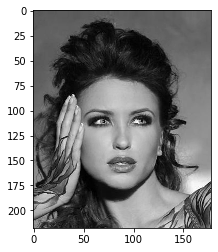

In [23]:
plt.imshow(input_face,cmap='gray');

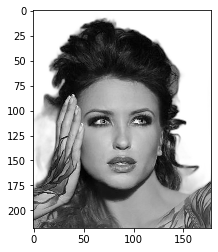

In [24]:
from rembg.bg import remove
import numpy as np
import io
from PIL import Image, ImageFile

success, encoded_image = cv2.imencode('.png', input_face)

result = remove(encoded_image)

img = Image.open(io.BytesIO(result)).convert("RGBA")
frame = np.array(img)
plt.imshow(frame, cmap='gray');

## Test de détection de visage

On va utiliser un modèle de openCV pour détécter les visages disponible ici : https://github.com/opencv/opencv/tree/master/data/haarcascades

In [25]:
cascPath = "cascade/haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cascPath)
gray = cv2.cvtColor(frame, cv2.COLOR_RGBA2GRAY)
detected_faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=6,
        minSize=(res, res),
        flags=cv2.CASCADE_SCALE_IMAGE
    )
detected_faces

array([[ 30,  65, 117, 117]], dtype=int32)

On trace un rectangle autour de chaque visage detecté

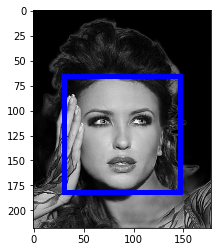

In [26]:
from matplotlib.patches import Rectangle
ax = plt.gca()
ax.imshow(gray, cmap='gray')
for (x, y, w, h) in detected_faces:
    ax.add_artist(Rectangle((x, y), w, h, fill=False, lw=5, color='blue'))

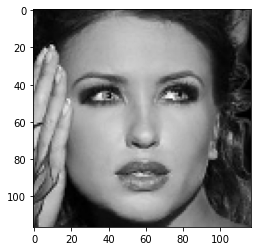

In [27]:
# pour que l'image extraite soit carrée
c = min(h,w)
extracted_face = gray[y+(h-c)//2:y+c, x+(w-c)//2:x+c]
plt.imshow(extracted_face, cmap='gray');

In [28]:
extracted_face_resized = cv2.resize(extracted_face, dsize=(res, res), interpolation=cv2.INTER_CUBIC)

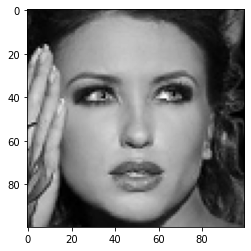

In [29]:
plt.imshow(extracted_face_resized, cmap='gray');

## Utilisation sur le dataset ...

In [30]:
def removebg(file):
    input_face = cv2.imread(file)
    success, encoded_image = cv2.imencode('.png', input_face)

    result = remove(encoded_image)

    img = Image.open(io.BytesIO(result)).convert("RGBA")
    frame = np.array(img)
    return frame

In [31]:
def detect_face(frame):
    cascPath = "cascade/haarcascade_frontalface_default.xml"
    faceCascade = cv2.CascadeClassifier(cascPath)
    gray = cv2.cvtColor(frame, cv2.COLOR_RGBA2GRAY)
    detected_faces = faceCascade.detectMultiScale(
            gray,
            scaleFactor=1.1,
            minNeighbors=6,
            minSize=(res, res),
            flags=cv2.CASCADE_SCALE_IMAGE
        )
    return gray, detected_faces

In [32]:
def extract_face_features(gray, detected_face):
    (x, y, w, h) = detected_face
    c = min(h,w)
    extracted_face = gray[y+(h-c)//2:y+c, x+(w-c)//2:x+c]
    extracted_face_resized = cv2.resize(extracted_face, dsize=(res, res), interpolation=cv2.INTER_CUBIC)
    return extracted_face_resized

In [33]:
def prepare_image(file):
    frame = removebg(file)
    gray1, face1 = detect_face(frame)

    if len(face1)==0 :
        print(file, "ko")

    else :
        return extract_face_features(gray1, face1[0])
        


In [34]:
from os import listdir
from os.path import isfile, join

def prepare_dir(dir_path = 'data/train_no_smile'):
    files = [join(dir_path, f) for f in listdir(dir_path) if isfile(join(dir_path, f))]

    faces = []

    for file in files :
        
        extracted_face = prepare_image(file)
        
        if not extracted_face is None :
            file_dest = join(dir_path, 'prepared', file.split('/')[-1])
            plt.imsave(file_dest, extracted_face, cmap='gray')

            faces.append(extracted_face)
        
            
    return faces

In [35]:
# prepare_dir(dir_path = 'data/train_no_smile')
# prepare_dir(dir_path = 'data/train_smile')

In [36]:
from os import listdir
from os.path import isfile, join

def load_faces(dir_path = 'data/train_no_smile/prepared'):
    files = [join(dir_path, f) for f in listdir(dir_path) if isfile(join(dir_path, f))]

    faces = [plt.imread(file) for file in files]
    return faces

Construction des données et de la target

In [37]:
data = []
y = []

faces = load_faces(dir_path = 'data/train_no_smile/prepared')
data.extend(faces)
y.extend([0]*len(faces))

faces = load_faces(dir_path = 'data/train_smile/prepared')
data.extend(faces)
y.extend([1]*len(faces))

In [38]:
len(data[0])

100

Affichage pour vérifier le résultat

In [39]:
def display_res(dir_parth = 'data/prepared/train_no_smile'):
    files = [join(dir_parth, f) for f in listdir(dir_parth) if isfile(join(dir_parth, f))]
    
    fig = plt.figure(figsize=(12, 12))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i, file in enumerate(files):
        face = cv2.imread(file)
        p = fig.add_subplot(20, 20, i + 1)
        p.imshow(face, cmap=plt.cm.bone)

        plt.axis('off')

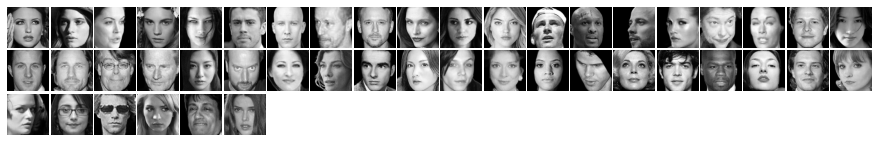

In [40]:
display_res(dir_parth = 'data/train_no_smile/prepared')

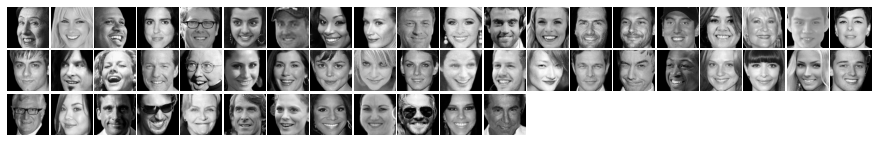

In [41]:
display_res(dir_parth = 'data/train_smile/prepared')

# Entrainement d'un modele

In [42]:
from sklearn.svm import SVC
svc = SVC(kernel='linear')

In [ ]:
d = [x.reshape([-1]) for x in data]

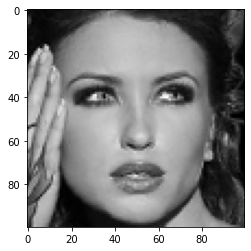

In [44]:
plt.imshow(data[0])

In [45]:
len(data[0])*len(data[0][0])

10000

In [46]:
len(d[0])

40000

In [47]:
from sklearn.model_selection import cross_val_score, KFold

cv = KFold(n_splits=10, shuffle=True, random_state=0)
scores = cross_val_score(svc, d, y, cv=cv)

print(f"Mean score: {scores.mean():.3f} (+/-{scores.std():.3f})")

Mean score: 0.756 (+/-0.175)


# Utilisation du modèle

In [48]:
svc.fit(d, y)

SVC(kernel='linear')

## Sur une image

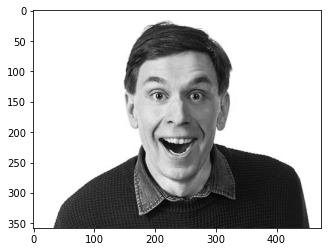

In [52]:
file = 'data/test/1.jpg'
face = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
plt.imshow(face, cmap = 'gray');

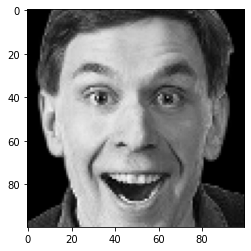

In [53]:
extracted_face = prepare_image(file)
plt.imshow(extracted_face, cmap = 'gray');

In [ ]:
svc.predict([extracted_face.reshape([-1])])[0]

## Avec la webcam

In [ ]:
cascPath = "cascade/haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cascPath)

video_capture = cv2.VideoCapture(0)

while True:
    # Capture frame-by-frame
    ret, frame = video_capture.read()

    # detect faces
    gray, detected_faces = detect_face(frame)
    
    face_index = 0
    
    # predict output
    for face in detected_faces:
        (x, y, w, h) = face
        if w > 100:
            # draw rectangle around face 
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            
            # extract features
            extracted_face = extract_face_features(gray, face) #(0.075, 0.05)

            # predict smile
            #prediction_result = svc.predict([extracted_face.reshape([-1])])[0]
            prediction_result = 1

            # draw extracted face in the top right corner
            frame[face_index * res: (face_index + 1) * res, -res-1:-1, :] = cv2.cvtColor(extracted_face * 255, cv2.COLOR_GRAY2RGB)

            # annotate main image with a label
            if prediction_result == 1:
                cv2.putText(frame, "SMILING",(x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, 155, 10)
            else:
                cv2.putText(frame, "not smiling",(x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, 155, 10)

            # increment counter
            face_index += 1
                

    # Display the resulting frame
    cv2.imshow('Video', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything is done, release the capture
video_capture.release()
cv2.destroyAllWindows()

In [ ]:
video_capture.release()